<a href="https://colab.research.google.com/github/IuliaMZbircea/CardioInsight/blob/main/Heart_Disease_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import os
import scipy as sc
import json
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import files

import sklearn as sk

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter

from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score,precision_score,classification_report,roc_auc_score,roc_curve

In [2]:
!pip install pyreadstat

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 10.3 MB/s eta 0:00:00


# 2. DATA ACQUISITION - Framingham Dataset



Import dataframe from Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df_fmg = pd.read_csv('/content/drive/MyDrive/Heart_Disease/frmgham2.csv')

# 3. EXPLORATORY DATA ANALYSIS

Snapshot of the dataframe:

In [5]:
df_fmg.head()

,RANDID,SEX,TOTCHOL,AGE,SYSBP,DIABP,CURSMOKE,CIGPDAY,BMI,DIABETES,...,CVD,HYPERTEN,TIMEAP,TIMEMI,TIMEMIFC,TIMECHD,TIMESTRK,TIMECVD,TIMEDTH,TIMEHYP
0,2448,1,195.0,39,106.0,70.0,0,0.0,26.97,0,...,1,0,8766,6438,6438,6438,8766,6438,8766,8766
1,2448,1,209.0,52,121.0,66.0,0,0.0,NaN,0,...,1,0,8766,6438,6438,6438,8766,6438,8766,8766
2,6238,2,250.0,46,121.0,81.0,0,0.0,28.73,0,...,0,0,8766,8766,8766,8766,8766,8766,8766,8766
3,6238,2,260.0,52,105.0,69.5,0,0.0,29.43,0,...,0,0,8766,8766,8766,8766,8766,8766,8766,8766
4,6238,2,237.0,58,108.0,66.0,0,0.0,28.50,0,...,0,0,8766,8766,8766,8766,8766,8766,8766,8766


Nr. of rows and columns of our dataframe:

In [6]:
df_fmg.shape

(11627, 39)

An overview of the nature of the dataframe's columns:

In [7]:
df_fmg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11627 entries, 0 to 11626
Data columns (total 39 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   RANDID    11627 non-null  int64  
 1   SEX       11627 non-null  int64  
 2   TOTCHOL   11218 non-null  float64
 3   AGE       11627 non-null  int64  
 4   SYSBP     11627 non-null  float64
 5   DIABP     11627 non-null  float64
 6   CURSMOKE  11627 non-null  int64  
 7   CIGPDAY   11548 non-null  float64
 8   BMI       11575 non-null  float64
 9   DIABETES  11627 non-null  int64  
 10  BPMEDS    11034 non-null  float64
 11  HEARTRTE  11621 non-null  float64
 12  GLUCOSE   10187 non-null  float64
 13  educ      11332 non-null  float64
 14  PREVCHD   11627 non-null  int64  
 15  PREVAP    11627 non-null  int64  
 16  PREVMI    11627 non-null  int64  
 17  PREVSTRK  11627 non-null  int64  
 18  PREVHYP   11627 non-null  int64  
 19  TIME      11627 non-null  int64  
 20  PERIOD    11627 non-null  in

To get statistical summaries of the data:

In [8]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
df_fmg.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
RANDID,11627.000,5004740.917,2900877.440,2448.000,2474378.000,5006008.000,7472730.000,9999312.000
SEX,11627.000,1.568,0.495,1.000,1.000,2.000,2.000,2.000
TOTCHOL,11218.000,241.162,45.368,107.000,210.000,238.000,268.000,696.000
AGE,11627.000,54.793,9.564,32.000,48.000,54.000,62.000,81.000
SYSBP,11627.000,136.324,22.799,83.500,120.000,132.000,149.000,295.000
DIABP,11627.000,83.038,11.660,30.000,75.000,82.000,90.000,150.000
CURSMOKE,11627.000,0.433,0.495,0.000,0.000,0.000,1.000,1.000
CIGPDAY,11548.000,8.250,12.187,0.000,0.000,0.000,20.000,90.000
BMI,11575.000,25.877,4.103,14.430,23.095,25.480,28.070,56.800
DIABETES,11627.000,0.046,0.209,0.000,0.000,0.000,0.000,1.000


In [9]:
df_fmg['CVD'].value_counts(normalize = True)

# df_fmg['ANGINA'].value_counts(normalize = True)

# df_fmg['STROKE'].value_counts(normalize = True)

# df_fmg['HYPERTEN'].value_counts(normalize = True)

0   0.751
1   0.249
Name: CVD, dtype: float64

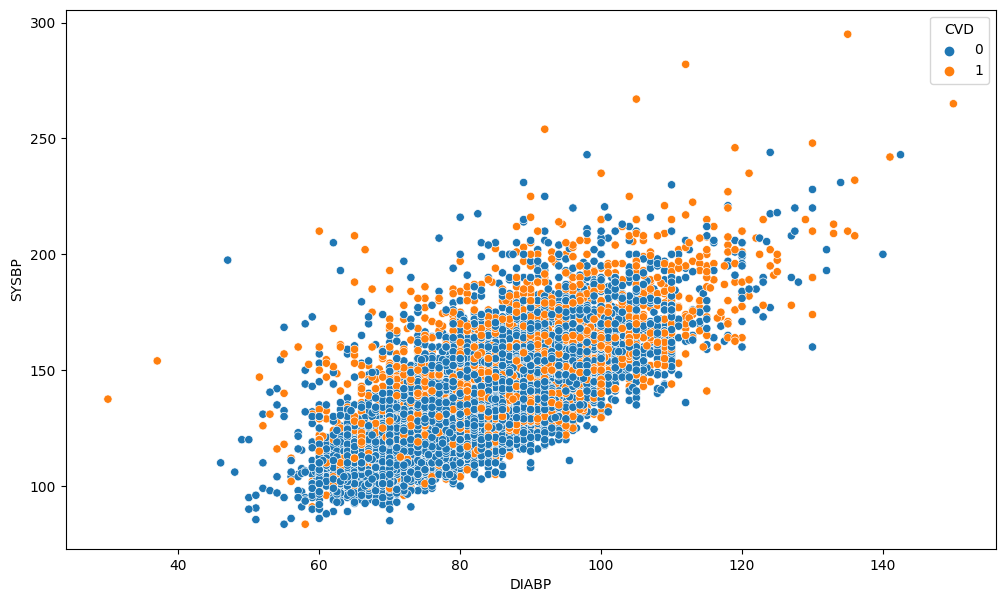

In [10]:
plt.figure(figsize = (12,7))
sns.scatterplot(data = df_fmg, y = 'SYSBP', x = 'DIABP', hue = 'CVD')    # or use regplot for trend line
plt.show()

# 4. FILTERING THE DATA

In [11]:
# delete unuseful data such as patients' RANDID and educ
df_fmg = df_fmg.drop(['RANDID'], axis = 1)
df_fmg = df_fmg.drop(['educ'], axis = 1)
df_fmg = df_fmg.drop(['TIMEAP'], axis = 1)
df_fmg = df_fmg.drop(['TIMEMI'], axis = 1)
df_fmg = df_fmg.drop(['TIMEMIFC'], axis = 1)
df_fmg = df_fmg.drop(['TIMECHD'], axis = 1)
df_fmg = df_fmg.drop(['TIMESTRK'], axis = 1)
df_fmg = df_fmg.drop(['TIMECVD'], axis = 1)
df_fmg = df_fmg.drop(['TIMEHYP'], axis = 1)
df_fmg = df_fmg.drop(['TIMEDTH'], axis = 1)
df_fmg = df_fmg.drop(['TIME'], axis = 1)

## 4.1 Detect missing values

In [12]:
# find missing value
df_fmg.isnull().sum()/len(df_fmg)*100

SEX         0.000
TOTCHOL     3.518
AGE         0.000
SYSBP       0.000
DIABP       0.000
CURSMOKE    0.000
CIGPDAY     0.679
BMI         0.447
DIABETES    0.000
BPMEDS      5.100
HEARTRTE    0.052
GLUCOSE    12.385
PREVCHD     0.000
PREVAP      0.000
PREVMI      0.000
PREVSTRK    0.000
PREVHYP     0.000
PERIOD      0.000
HDLC       73.966
LDLC       73.974
DEATH       0.000
ANGINA      0.000
HOSPMI      0.000
MI_FCHD     0.000
ANYCHD      0.000
STROKE      0.000
CVD         0.000
HYPERTEN    0.000
dtype: float64

In [13]:
import missingno as msno

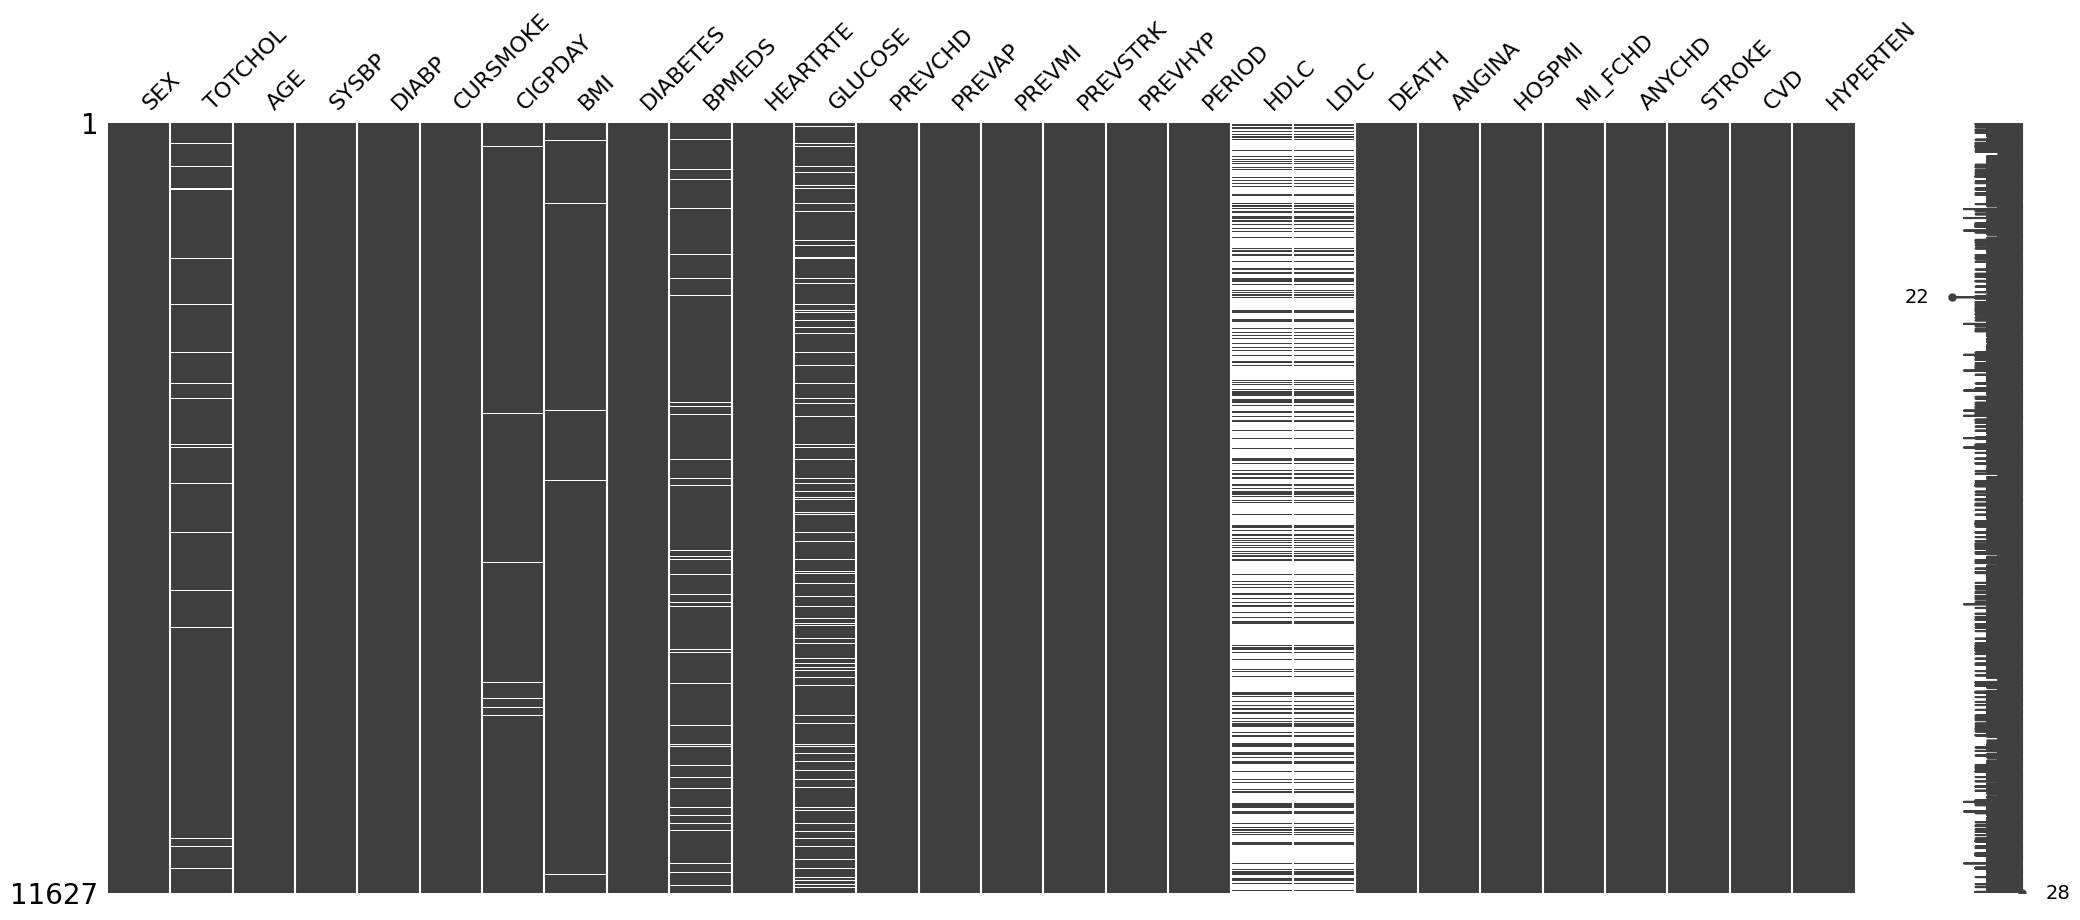

In [14]:
# relative missingness of columns using matrix
msno.matrix(df_fmg)
plt.show()

## 4.2 Dealing with Missing Values

In [15]:
# Replace missing values with average
df_fmg['TOTCHOL'] = df_fmg['TOTCHOL'].fillna(df_fmg['TOTCHOL'].mean())
df_fmg['BMI'] = df_fmg['BMI'].fillna(df_fmg['BMI'].mean())
df_fmg['BPMEDS'] = df_fmg['BPMEDS'].fillna(df_fmg['BPMEDS'].mean())
df_fmg['GLUCOSE'] = df_fmg['GLUCOSE'].fillna(df_fmg['GLUCOSE'].mean())
df_fmg['HDLC'] = df_fmg['HDLC'].fillna(df_fmg['HDLC'].mean())
df_fmg['LDLC'] = df_fmg['LDLC'].fillna(df_fmg['LDLC'].mean())
df_fmg['HEARTRTE'] = df_fmg['HEARTRTE'].fillna(df_fmg['HEARTRTE'].mean())
df_fmg['CIGPDAY'] = df_fmg['CIGPDAY'].fillna(df_fmg['CIGPDAY'].mean())

In [16]:
# find missing value
df_fmg.isnull().sum()/len(df_fmg)*100

SEX        0.000
TOTCHOL    0.000
AGE        0.000
SYSBP      0.000
DIABP      0.000
CURSMOKE   0.000
CIGPDAY    0.000
BMI        0.000
DIABETES   0.000
BPMEDS     0.000
HEARTRTE   0.000
GLUCOSE    0.000
PREVCHD    0.000
PREVAP     0.000
PREVMI     0.000
PREVSTRK   0.000
PREVHYP    0.000
PERIOD     0.000
HDLC       0.000
LDLC       0.000
DEATH      0.000
ANGINA     0.000
HOSPMI     0.000
MI_FCHD    0.000
ANYCHD     0.000
STROKE     0.000
CVD        0.000
HYPERTEN   0.000
dtype: float64

In [17]:
# Check for row duplication
df_fmg.duplicated().sum()

0

<Figure size 2000x2000 with 0 Axes>

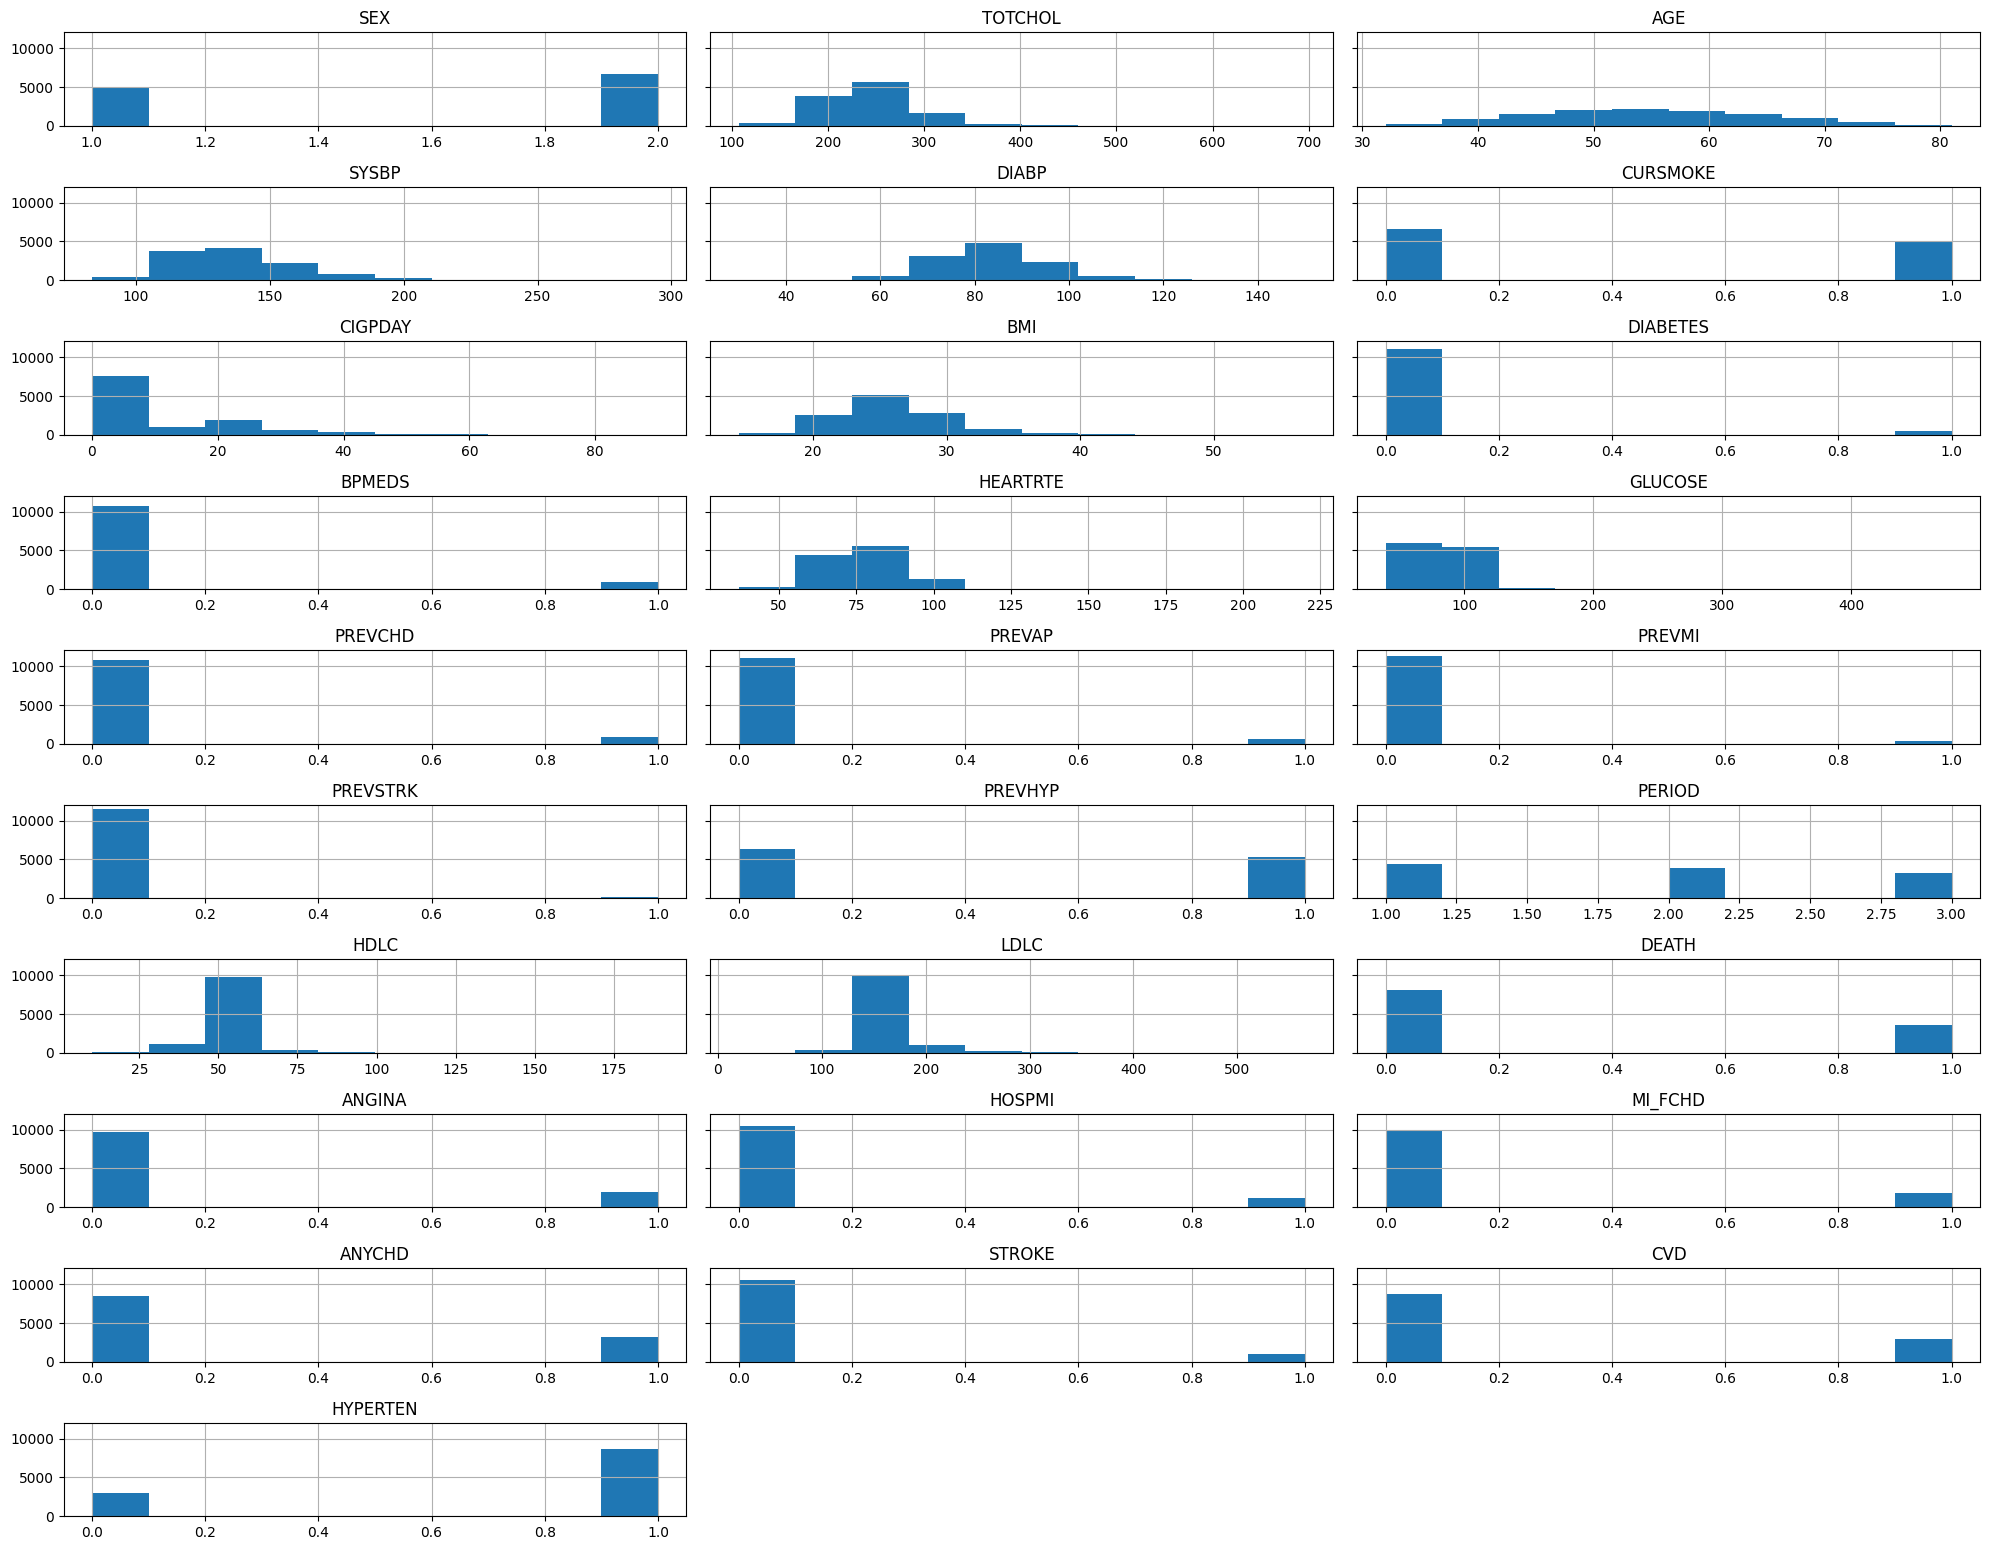

In [18]:
plt.figure(figsize=(20, 20))

df_fmg.hist(layout=(13, 3), figsize=(20, 20), sharey=True)

plt.tight_layout()

plt.show()

# 5. CORRELATION AMONG CATEGORIES



In [19]:
corr_fmg = df_fmg.corr(method = 'pearson')
corr_fmg

,SEX,TOTCHOL,AGE,SYSBP,DIABP,CURSMOKE,CIGPDAY,BMI,DIABETES,BPMEDS,...,HDLC,LDLC,DEATH,ANGINA,HOSPMI,MI_FCHD,ANYCHD,STROKE,CVD,HYPERTEN
SEX,1.000,0.132,0.027,0.048,-0.049,-0.148,-0.242,-0.069,-0.020,0.081,...,0.161,0.056,-0.149,-0.074,-0.179,-0.198,-0.157,-0.018,-0.175,0.019
TOTCHOL,0.132,1.000,0.147,0.147,0.127,-0.041,-0.033,0.078,0.003,0.061,...,0.090,0.436,0.032,0.097,0.085,0.094,0.109,0.011,0.075,0.099
AGE,0.027,0.147,1.000,0.389,0.069,-0.253,-0.227,0.060,0.137,0.196,...,-0.005,0.005,0.310,0.108,0.061,0.111,0.164,0.185,0.210,0.199
SYSBP,0.048,0.147,0.389,1.000,0.712,-0.141,-0.102,0.274,0.145,0.321,...,-0.006,0.032,0.261,0.116,0.092,0.156,0.193,0.204,0.228,0.493
DIABP,-0.049,0.127,0.069,0.712,1.000,-0.076,-0.035,0.337,0.032,0.223,...,-0.011,0.021,0.137,0.078,0.063,0.114,0.135,0.137,0.159,0.419
CURSMOKE,-0.148,-0.041,-0.253,-0.141,-0.076,1.000,0.778,-0.165,-0.043,-0.084,...,-0.011,-0.004,0.027,-0.036,0.050,0.044,-0.001,-0.009,0.023,-0.116
CIGPDAY,-0.242,-0.033,-0.227,-0.102,-0.035,0.778,1.000,-0.102,-0.041,-0.080,...,-0.021,-0.003,0.041,-0.028,0.057,0.055,0.015,-0.010,0.032,-0.080
BMI,-0.069,0.078,0.060,0.274,0.337,-0.165,-0.102,1.000,0.090,0.101,...,-0.091,0.034,0.049,0.093,0.049,0.074,0.119,0.067,0.108,0.221
DIABETES,-0.020,0.003,0.137,0.145,0.032,-0.043,-0.041,0.090,1.000,0.084,...,-0.033,-0.014,0.148,0.072,0.090,0.124,0.126,0.114,0.156,0.069
BPMEDS,0.081,0.061,0.196,0.321,0.223,-0.084,-0.080,0.101,0.084,1.000,...,-0.016,0.044,0.106,0.083,0.030,0.064,0.099,0.127,0.111,0.177


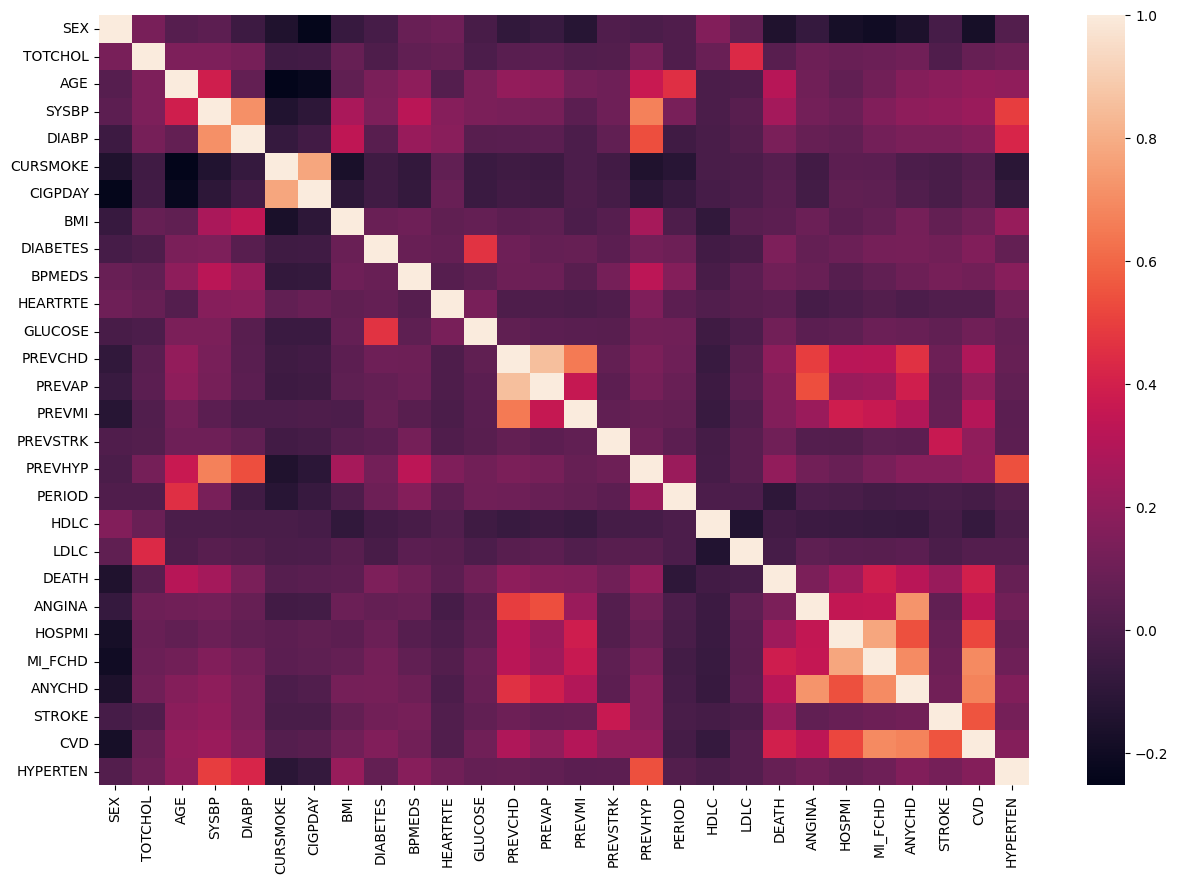

In [20]:
## using a heatmeap for easy understanding of our data
plt.figure(figsize = (15, 10))
sns.heatmap(corr_fmg)
plt.show()

In [21]:
corr_targ_CVD = df_fmg.corr()['CVD'].abs().sort_values(ascending = False)
corr_targ_CVD

# corr_targ_ANGINA = df_fmg.corr()['ANGINA'].abs().sort_values()
# corr_targ_ANGINA

# corr_targ_STROKE = df_fmg.corr()['STROKE'].abs().sort_values()
# corr_targ_STROKE

# corr_targ_HYPERTEN = df_fmg.corr()['HYPERTEN'].abs().sort_values()
# corr_targ_HYPERTEN

CVD        1.000
MI_FCHD    0.693
ANYCHD     0.674
STROKE     0.550
HOSPMI     0.519
DEATH      0.396
ANGINA     0.333
PREVMI     0.302
PREVCHD    0.288
SYSBP      0.228
AGE        0.210
PREVHYP    0.207
PREVAP     0.202
PREVSTRK   0.200
SEX        0.175
HYPERTEN   0.166
DIABP      0.159
DIABETES   0.156
BPMEDS     0.111
BMI        0.108
GLUCOSE    0.107
TOTCHOL    0.075
HDLC       0.074
CIGPDAY    0.032
PERIOD     0.025
LDLC       0.025
CURSMOKE   0.023
HEARTRTE   0.013
Name: CVD, dtype: float64

In [22]:
# plt.figure(figsize=(30, 60))

# for i, column in enumerate(df_fmg.columns):
#     plt.subplot(39, 1, i + 1)
#     sns.countplot(x=column, hue='CVD', data=df_fmg)

# plt.tight_layout()
# plt.subplots_adjust(hspace=0.5, wspace=0.3)

# plt.show()

# 6. Data Preprocessing


## 6.1 Splitting the dataset into training and testing data

In [23]:
df_fmg.shape

(11627, 28)

In [24]:
df_fmg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11627 entries, 0 to 11626
Data columns (total 28 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SEX       11627 non-null  int64  
 1   TOTCHOL   11627 non-null  float64
 2   AGE       11627 non-null  int64  
 3   SYSBP     11627 non-null  float64
 4   DIABP     11627 non-null  float64
 5   CURSMOKE  11627 non-null  int64  
 6   CIGPDAY   11627 non-null  float64
 7   BMI       11627 non-null  float64
 8   DIABETES  11627 non-null  int64  
 9   BPMEDS    11627 non-null  float64
 10  HEARTRTE  11627 non-null  float64
 11  GLUCOSE   11627 non-null  float64
 12  PREVCHD   11627 non-null  int64  
 13  PREVAP    11627 non-null  int64  
 14  PREVMI    11627 non-null  int64  
 15  PREVSTRK  11627 non-null  int64  
 16  PREVHYP   11627 non-null  int64  
 17  PERIOD    11627 non-null  int64  
 18  HDLC      11627 non-null  float64
 19  LDLC      11627 non-null  float64
 20  DEATH     11627 non-null  in

In [25]:
df_fmg.columns

Index(['SEX', 'TOTCHOL', 'AGE', 'SYSBP', 'DIABP', 'CURSMOKE', 'CIGPDAY', 'BMI',
       'DIABETES', 'BPMEDS', 'HEARTRTE', 'GLUCOSE', 'PREVCHD', 'PREVAP',
       'PREVMI', 'PREVSTRK', 'PREVHYP', 'PERIOD', 'HDLC', 'LDLC', 'DEATH',
       'ANGINA', 'HOSPMI', 'MI_FCHD', 'ANYCHD', 'STROKE', 'CVD', 'HYPERTEN'],
      dtype='object')

## 6.2 Models


The five algorithms used are:
1. k-Nearest Neighbours
2. Logistic Regression
3. Decision Trees
4. Support Vector Machine
5. Random Forest Classifier

### 1. K-Nearest Neighbors

GridSearchCV: Used for performing grid search with cross-validation to find the best hyperparameters.

K-Nearest Neighbors (KNN) is a straightforward machine learning algorithm used for classification and regression. During the training phase, it stores all training data points and their labels. When predicting the class or value for a new data point, KNN identifies the 'k' nearest neighbors based on distances, typically using Euclidean distance. For classification, it takes a majority vote among the neighbors to determine the class, while for regression, it calculates the average of the target values. The choice of 'k' and the distance metric are essential parameters, influencing the algorithm's sensitivity and performance. KNN is non-parametric, making no assumptions about data distribution, and lazy learning, as it doesn't build an explicit model during training. It is effective in scenarios with complex patterns and undefined decision boundaries, but its computational cost may pose challenges with large datasets.

In [26]:
# Create separate target variables for each condition
y_stroke = df_fmg['STROKE'].values
y_hyperten = df_fmg['HYPERTEN'].values
y_angina = df_fmg['ANGINA'].values

In [27]:
# Split the data into features (X) and each target variable
X = df_fmg.iloc[:, 0:28].values

# Split the data into training and testing sets
X_train, X_test, y_stroke_train, y_stroke_test = train_test_split(X, y_stroke, test_size=0.2, random_state=42)
X_train, X_test, y_hyperten_train, y_hyperten_test = train_test_split(X, y_hyperten, test_size=0.2, random_state=42)
X_train, X_test, y_angina_train, y_angina_test = train_test_split(X, y_angina, test_size=0.2, random_state=42)


In [40]:
print("Stroke - Training samples:", len(y_stroke_train), "Testing samples:", len(y_stroke_test))
print("Hyperten - Training samples:", len(y_hyperten_train), "Testing samples:", len(y_hyperten_test))
print("Angina - Training samples:", len(y_angina_train), "Testing samples:", len(y_angina_test))

Stroke - Training samples: 9301 Testing samples: 2326
Hyperten - Training samples: 9301 Testing samples: 2326
Angina - Training samples: 9301 Testing samples: 2326


In [28]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [29]:
# Convert back to DataFrames with column names
X_train = pd.DataFrame(X_train_scaled, columns=df_fmg.columns[0:28])
X_test = pd.DataFrame(X_test_scaled, columns=df_fmg.columns[0:28])

# Perform GridSearchCV for K-Nearest Neighbors for each condition
params = {'n_neighbors': np.arange(1, 10)}


In [30]:
# Stroke
grid_search_stroke = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=params,
                                   scoring='accuracy', cv=10, n_jobs=-1)
grid_search_stroke.fit(X_train, y_stroke_train)
best_params_stroke = grid_search_stroke.best_params_
knn_predict_stroke = grid_search_stroke.predict(X_test)
knn_accuracy_stroke = accuracy_score(y_stroke_test, knn_predict_stroke)


print("Stroke Model - Best Parameters:", best_params_stroke)
print(f"Stroke Model Accuracy: {round(knn_accuracy_stroke * 100, 2)}%")



Stroke Model - Best Parameters: {'n_neighbors': 5}
Stroke Model Accuracy: 99.66%


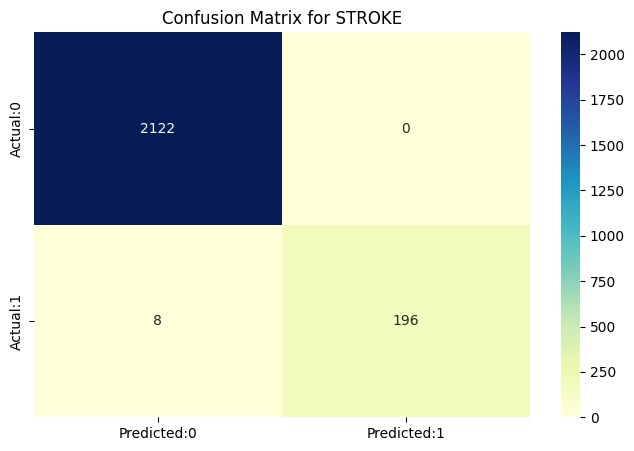

In [31]:
cm_stroke = confusion_matrix(y_stroke_test, knn_predict_stroke)
conf_matrix_stroke = pd.DataFrame(data=cm_stroke, columns=['Predicted:0', 'Predicted:1'], index=['Actual:0', 'Actual:1'])
plt.figure(figsize=(8, 5))
plt.title('Confusion Matrix for STROKE')
sns.heatmap(conf_matrix_stroke, annot=True, fmt='d', cmap="YlGnBu")
plt.show()

In [32]:
# Classification Report for STROKE
classification_report_stroke = classification_report(y_stroke_test, knn_predict_stroke)
print("Classification Report for STROKE:")
print(classification_report_stroke)

Classification Report for STROKE:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2122
           1       1.00      0.96      0.98       204

    accuracy                           1.00      2326
   macro avg       1.00      0.98      0.99      2326
weighted avg       1.00      1.00      1.00      2326



In [33]:
# Hyperten
grid_search_hyperten = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=params,
                                     scoring='accuracy', cv=10, n_jobs=-1)
grid_search_hyperten.fit(X_train, y_hyperten_train)
best_params_hyperten = grid_search_hyperten.best_params_
knn_predict_hyperten = grid_search_hyperten.predict(X_test)
knn_accuracy_hyperten = accuracy_score(y_hyperten_test, knn_predict_hyperten)

print("Hyperten Model - Best Parameters:", best_params_hyperten)
print(f"Hyperten Model Accuracy: {round(knn_accuracy_hyperten * 100, 2)}%")


Hyperten Model - Best Parameters: {'n_neighbors': 6}
Hyperten Model Accuracy: 99.36%


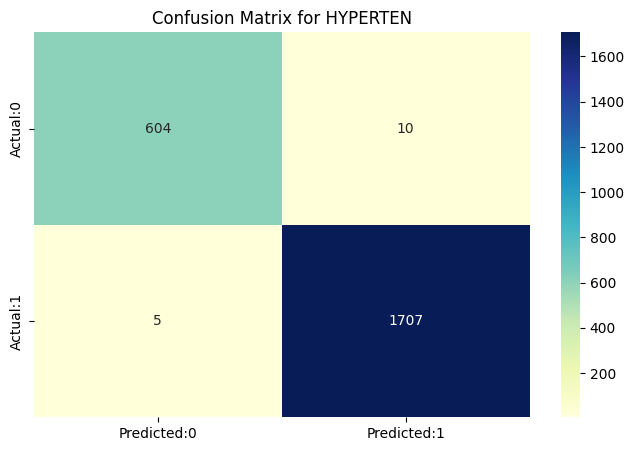

In [34]:
# Confusion Matrix and Visualization for HYPERTEN
cm_hyperten = confusion_matrix(y_hyperten_test, knn_predict_hyperten)
conf_matrix_hyperten = pd.DataFrame(data=cm_hyperten, columns=['Predicted:0', 'Predicted:1'], index=['Actual:0', 'Actual:1'])
plt.figure(figsize=(8, 5))
plt.title('Confusion Matrix for HYPERTEN')
sns.heatmap(conf_matrix_hyperten, annot=True, fmt='d', cmap="YlGnBu")
plt.show()

In [35]:
# Classification Report for HYPERTEN
classification_report_hyperten = classification_report(y_hyperten_test, knn_predict_hyperten)
print("\nClassification Report for HYPERTEN:")
print(classification_report_hyperten)


Classification Report for HYPERTEN:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       614
           1       0.99      1.00      1.00      1712

    accuracy                           0.99      2326
   macro avg       0.99      0.99      0.99      2326
weighted avg       0.99      0.99      0.99      2326



In [36]:
# Angina
grid_search_angina = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=params,
                                  scoring='accuracy', cv=10, n_jobs=-1)
grid_search_angina.fit(X_train, y_angina_train)
best_params_angina = grid_search_angina.best_params_
knn_predict_angina = grid_search_angina.predict(X_test)
knn_accuracy_angina = accuracy_score(y_angina_test, knn_predict_angina)

print("Angina Model - Best Parameters:", best_params_angina)
print(f"Angina Model Accuracy: {round(knn_accuracy_angina * 100, 2)}%")

Angina Model - Best Parameters: {'n_neighbors': 3}
Angina Model Accuracy: 99.36%


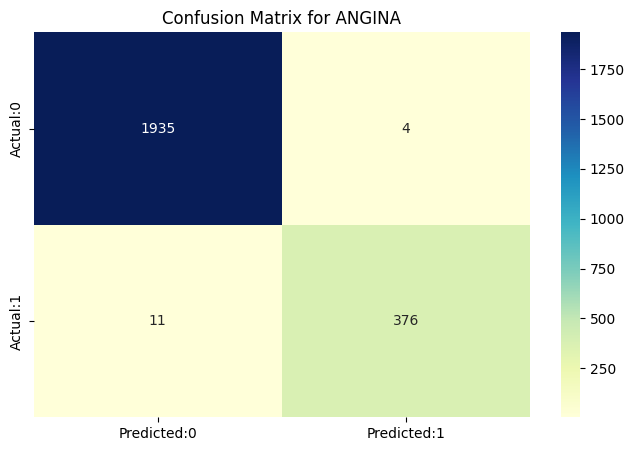

In [37]:
# Confusion Matrix and Visualization for ANGINA
cm_angina = confusion_matrix(y_angina_test, knn_predict_angina)
conf_matrix_angina = pd.DataFrame(data=cm_angina, columns=['Predicted:0', 'Predicted:1'], index=['Actual:0', 'Actual:1'])
plt.figure(figsize=(8, 5))
plt.title('Confusion Matrix for ANGINA')
sns.heatmap(conf_matrix_angina, annot=True, fmt='d', cmap="YlGnBu")
plt.show()


In [38]:
classification_report_angina = classification_report(y_angina_test, knn_predict_angina)
print("\nClassification Report for ANGINA:")
print(classification_report_angina)


Classification Report for ANGINA:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1939
           1       0.99      0.97      0.98       387

    accuracy                           0.99      2326
   macro avg       0.99      0.98      0.99      2326
weighted avg       0.99      0.99      0.99      2326

